In [1]:
using Distributions
using FiniteDifferences
using Roots
using StatsPlots
default(fmt=:png)

x ⪅ y = x < y || x ≈ y
safediv(x, y) = x == 0 ? zero(x/y) : x/y

function pvalue_sterne(x, n, p)
    bin = Binomial(n, p)
    sum(pdf(bin, i) for i in support(bin) if pdf(bin, i) ⪅ pdf(bin, x))
end

function pvalue_score(x, n, p)
    bin = Binomial(n, p)
    z = safediv(x - mean(bin), std(bin))
    2ccdf(Normal(), abs(z))
end

function posterior_bin(x, n; prior=Beta(1, 1))
    a, b = params(prior)
    Beta(a+x, b+n-x)
end

function pvalue_bayes_eti(x, n, p; prior=Beta(1/3, 1/3))
    posterior = posterior_bin(x, n; prior)
    #min(1, 2cdf(posterior, p), 2ccdf(posterior, p))
    min(2cdf(posterior, p), 2ccdf(posterior, p))
end

function pvalue_hdi(dist::ContinuousUnivariateDistribution, x₀; xlim = extrema(dist))
    p₀ = pdf(dist, x₀)
    xmode = mode(dist)
    f(x) = pdf(dist, x) - p₀
    if x₀ == xmode
        1.0
    elseif x₀ > xmode
        x₁ = find_zero(f, (xlim[begin], xmode))
        cdf(dist, x₁) + ccdf(dist, x₀)
    else
        x₁ = find_zero(f, (xmode, xlim[end]))
        cdf(dist, x₀) + ccdf(dist, x₁)
    end
end

function pvalue_bayes_hdi(x, n, p; prior=Beta(1, 1))
    posterior = posterior_bin(x, n; prior)
    a, b = params(posterior)
    if a == 1 && b == 1
        1.0
    elseif a ≤ 1
        ccdf(posterior, p)
    elseif b ≤ 1
        cdf(posterior, p)
    else
        pvalue_hdi(posterior, p)
    end
end

function pval2pdfhdi(pvalfunc, xcenter, xmin, xmax)
    Db = backward_fdm(5, 1)
    Df = forward_fdm(5, 1)
    function pdfhdi(x)
        pval_x = pvalfunc(x)
        f(x) = pvalfunc(x) - pval_x
        if x == xcenter
            a = Db(pvalfunc, x)
            b = Df(pvalfunc, x)
        elseif x < xcenter
            y = find_zero(f, (xcenter, xmax))
            a = Db(pvalfunc, x)
            b = Df(pvalfunc, y)
        else
            y = find_zero(f, (xmin, xcenter))
            a = Db(pvalfunc, y)
            b = Df(pvalfunc, x)
        end
        safediv(a*b, b - a)
    end
    pdfhdi
end

function pval2pdfeti(pvalfunc, xcenter)
    Db = backward_fdm(5, 1)
    Df = forward_fdm(5, 1)
    function pdfeti(x)
        if x == xcenter
            (Db(pvalfunc, x) - Df(pvalfunc, x)) / 4
        elseif x < xcenter
            Db(pvalfunc, x) / 2
        else
            -Df(pvalfunc, x) / 2
        end
    end
    pdfeti
end

pval2pdfeti (generic function with 1 method)

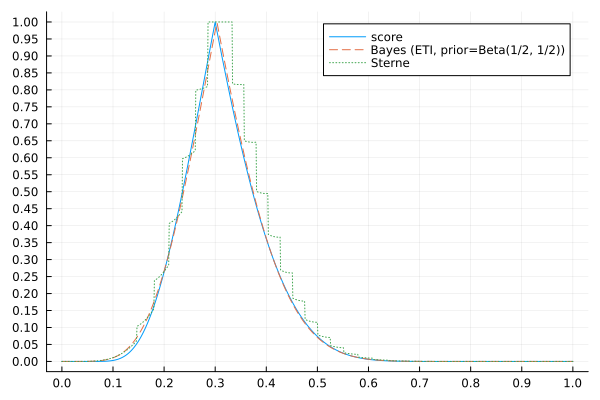

In [2]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_eti(x, n, p; prior=Beta(1/2, 1/2));
    label="Bayes (ETI, prior=Beta(1/2, 1/2))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)

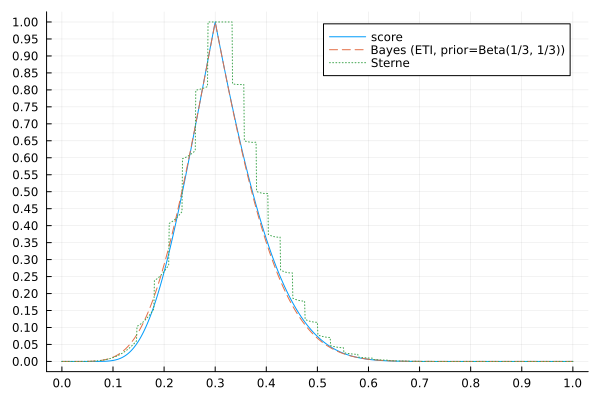

In [3]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_eti(x, n, p; prior=Beta(1/3, 1/3));
    label="Bayes (ETI, prior=Beta(1/3, 1/3))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)

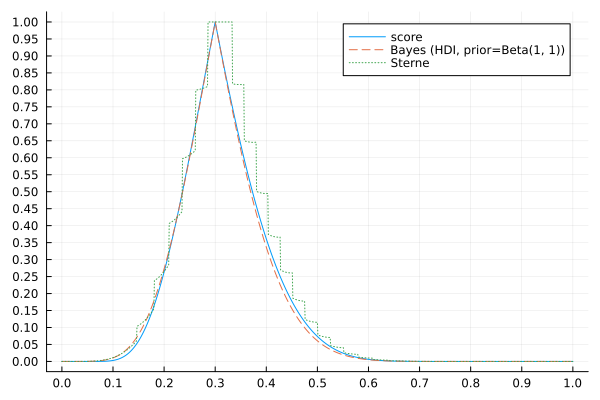

In [4]:
x, n = 6, 20
ps = 0:0.001:1
plot(ps, p -> pvalue_score(x, n, p); label="score")
plot!(ps, p -> pvalue_bayes_hdi(x, n, p; prior=Beta(1, 1));
    label="Bayes (HDI, prior=Beta(1, 1))", ls=:dash)
plot!(ps, p -> pvalue_sterne(x, n, p); label="Sterne", ls=:dot)
plot!(xtick=0:0.1:1, ytick=0:0.05:1)

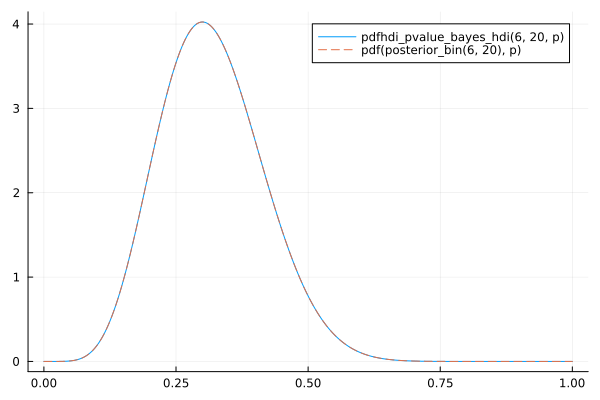

In [5]:
pdfhdi_pvalue_bayes_hdi = pval2pdfhdi(p -> pvalue_bayes_hdi(6, 20, p), 0.3, 0.0, 1.0)
ps = 0:0.001:1
plot(ps, pdfhdi_pvalue_bayes_hdi; label="pdfhdi_pvalue_bayes_hdi(6, 20, p)")
plot!(ps, p -> pdf(posterior_bin(6, 20), p); label="pdf(posterior_bin(6, 20), p)", ls=:dash)

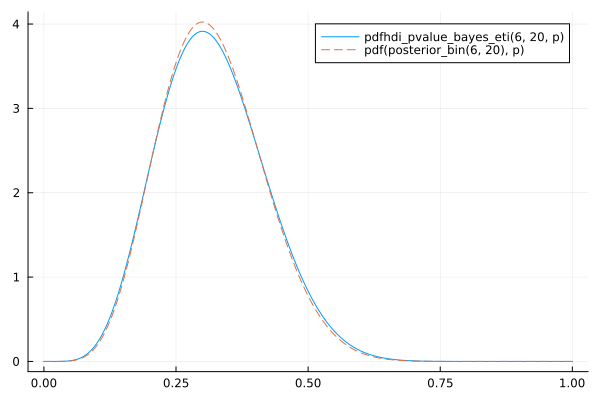

In [6]:
prior = Beta(1/3, 1/3)
pcenter = median(posterior_bin(6, 20; prior))
pdfhdi_pvalue_bayes_eti = pval2pdfhdi(p -> pvalue_bayes_eti(6, 20, p; prior), pcenter, 0.0, 1.0)
ps = 0:0.001:1
plot(ps, pdfhdi_pvalue_bayes_eti; label="pdfhdi_pvalue_bayes_eti(6, 20, p)")
plot!(ps, p -> pdf(posterior_bin(6, 20), p); label="pdf(posterior_bin(6, 20), p)", ls=:dash)

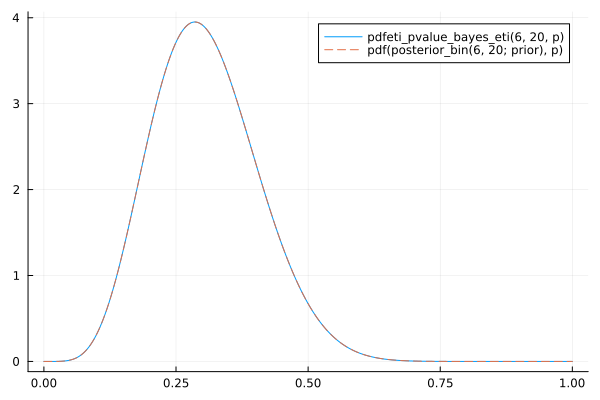

In [7]:
prior = Beta(1/3, 1/3)
pcenter = median(posterior_bin(6, 20; prior))
pdfeti_pvalue_bayes_eti = pval2pdfeti(p -> pvalue_bayes_eti(6, 20, p; prior), pcenter)
ps = 0:0.001:1
plot(ps, pdfeti_pvalue_bayes_eti; label="pdfeti_pvalue_bayes_eti(6, 20, p)")
plot!(ps, p -> pdf(posterior_bin(6, 20; prior), p); label="pdf(posterior_bin(6, 20; prior), p)", ls=:dash)

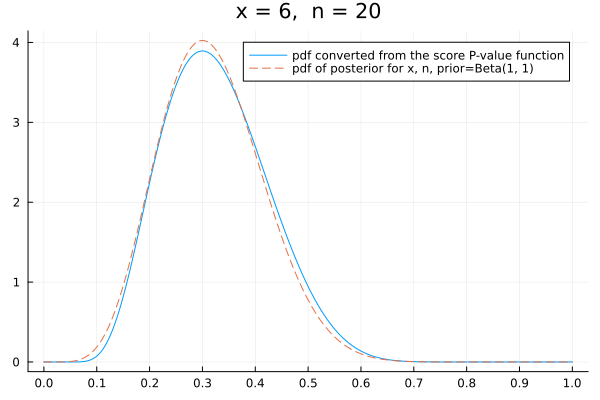

In [8]:
x, n = 6, 20
pdfhdi_pvalue_score =
    pval2pdfhdi(p -> pvalue_score(x, n, clamp(p, 0.0, 1.0)), x/n, 0.0, 1.0)
ps = 0:0.001:1
plot(ps, pdfhdi_pvalue_score; label="pdf converted from the score P-value function")
plot!(ps, p -> pdf(posterior_bin(x, n; prior=Beta(1, 1)), p);
    label="pdf of posterior for x, n, prior=Beta(1, 1)", ls=:dash)
plot!(xtick=0:0.1:1)
title!("x = $x,  n = $n")

In [9]:
using QuadGK
quadgk(pdfhdi_pvalue_score, 0, 1)

(1.000000000000218, 1.5432419842416472e-10)

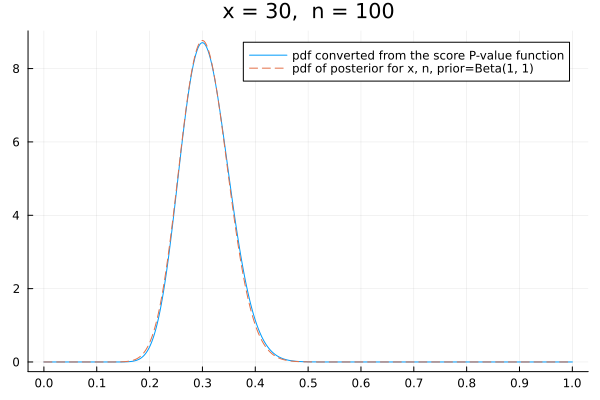

In [10]:
x, n = 30, 100
pdfhdi_pvalue_score =
    pval2pdfhdi(p -> pvalue_score(x, n, clamp(p, 0.0, 1.0)), x/n, 0.0, 1.0)
ps = 0:0.001:1
plot(ps, pdfhdi_pvalue_score; label="pdf converted from the score P-value function")
plot!(ps, p -> pdf(posterior_bin(x, n; prior=Beta(1, 1)), p);
    label="pdf of posterior for x, n, prior=Beta(1, 1)", ls=:dash)
plot!(xtick=0:0.1:1)
title!("x = $x,  n = $n")

In [11]:
using QuadGK
quadgk(pdfhdi_pvalue_score, 0, 1)

(1.0000000000016311, 6.390430009504594e-9)